In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 495.1 kB/s eta 0:00:00


In [2]:
import os
import pandas as pd
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from itertools import cycle
import einops
from tqdm.auto import tqdm
import random
from torch.distributions import Categorical

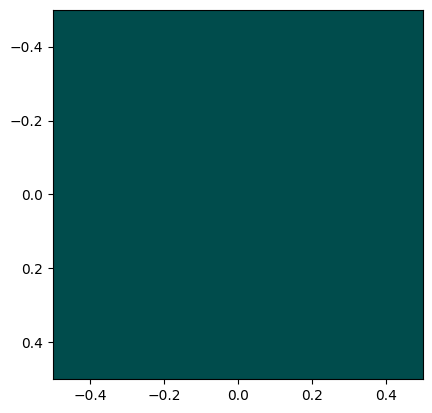

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random pixel values for the image
image_data = np.random.rand(1, 1, 3)  # 100x100 image with 3 color channels (RGB)
image_data[0,0,:] = 0.3
image_data[0,0,0] = 0
# Display the image
plt.imshow(image_data)
plt.show()

In [4]:
import os
import pandas as pd
from torchvision.io import read_image
import numpy as np

class CustomImageDataset(Dataset):
    def __init__(self):
      self.num_images = 1000
      self.images = np.random.rand(self.num_images,1,1,3)

    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      return self.images[idx]

In [5]:
training_dataset = CustomImageDataset()

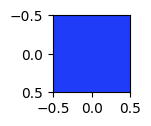

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(1, 1))
plt.imshow(training_dataset[83])
plt.show()

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_dataset, batch_size=128, shuffle=True, drop_last=True)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomSender(nn.Module):
    def __init__(self):
        super(CustomSender, self).__init__()
        self.num_words = 10
        # Define your layers or modules here
        self.fc1 = nn.Linear(in_features=3, out_features=self.num_words)


    def forward(self, x):
        x = self.fc1(x.flatten(start_dim=1))
        # x = nn.functional.relu(x)
        # x = self.fc2(x)
        return x


class CustomReceiver(nn.Module):
    def __init__(self):
        super(CustomReceiver, self).__init__()
        self.num_words = 10
        self.fc1 = nn.Linear(in_features=3, out_features=16)
        self.emb = nn.Embedding(self.num_words, 16)

    def forward_image(self, x):
        x = self.fc1(x.flatten(start_dim=1))
        # x = nn.functional.relu(x)
        # x = self.fc2(x)
        return x

    def forward_text(self, x):
        x = F.sigmoid(self.emb(x))
        return x


In [20]:
m1 = CustomSender()
x = torch.randn(32,1,1,3)
alphs = m1(x).argmax(1)
m2 = CustomReceiver()
m2_img_rprs = m2.forward_image(x)
m2_text_rprs = m2.forward_text(alphs)
alphs

tensor([5, 3, 1, 1, 5, 3, 9, 1, 5, 5, 5, 1, 4, 1, 5, 5, 5, 5, 9, 1, 1, 1, 9, 1,
        9, 5, 3, 3, 0, 4, 4, 5])

In [21]:
m2_optimizer = torch.optim.Adam(m2.parameters(), lr=1e-3)
m1_optimizer = torch.optim.Adam(m1.parameters(), lr=1e-3)

In [22]:
import time
from torch.distributions import Categorical

data_iterator = iter(train_dataloader)
acc_list = []
loss_list = []
best_acc = 0
for iter_num in tqdm(range(30000)):
  try:
    batch = next(data_iterator)
  except StopIteration:
    data_iterator = iter(train_dataloader)
    batch = next(data_iterator)
  m2_optimizer.zero_grad()
  m1_optimizer.zero_grad()
  #####
  message_logits = m1(batch.float())
  message = message_logits.argmax(1)
  m2_img_rprs = m2.forward_image(batch.float())
  m2_mess_rprs = m2.forward_text(message)
  rolled_m2_img_rprs = torch.roll(m2_img_rprs, shifts=1, dims=0)
  pos_similarity = F.cosine_similarity(m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  neg_similarity = F.cosine_similarity(rolled_m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  similarity_scores = torch.cat([pos_similarity, neg_similarity], axis=1)
  m2_loss = F.cross_entropy(similarity_scores, torch.LongTensor([0]*similarity_scores.shape[0]))
  m2_loss.backward()
  m2_optimizer.step()
  ########
  log_probs = torch.log(torch.gather(F.softmax(message_logits, dim=1), 1, message.unsqueeze(1)))
  similarity_scores += 0.001 * torch.randn_like(similarity_scores)
  rewards = 1 - similarity_scores.argmax(1).float()
  returns = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
  m1_loss = -torch.mean(returns * log_probs)
  entropy_loss = -Categorical(F.softmax(message_logits, dim=1)).entropy().sum()
  m1_loss = m1_loss + 1e-3*entropy_loss
  ####

  #####
  m1_loss.backward()
  m1_optimizer.step()
  acc = (1 - similarity_scores.argmax(1)).float().mean()
  acc_list.append(acc)
  loss_list.append(m2_loss.item())
  if acc > best_acc:
    print(acc)
    best_acc = acc
  if acc.item() > 0.95:
    print(acc.item())
    break
  if iter_num % 1000 == 0:
    print(rewards.mean(), m2_loss.item(), entropy_loss.item())

  0%|          | 0/30000 [00:00<?, ?it/s]

tensor(0.5391)
tensor(0.5391) 0.694441020488739 -286.92291259765625
tensor(0.5547)
tensor(0.5703)
tensor(0.6094)
tensor(0.6719)
tensor(0.6797)
tensor(0.7031)
tensor(0.7422)
tensor(0.7734)
tensor(0.7812)
tensor(0.7891)
tensor(0.7969)
tensor(0.8125)
tensor(0.8281)
tensor(0.8516)
tensor(0.8594)
tensor(0.8828)
tensor(0.8906)
tensor(0.8984)
tensor(0.9375)
tensor(0.9453)
tensor(0.9609)
0.9609375


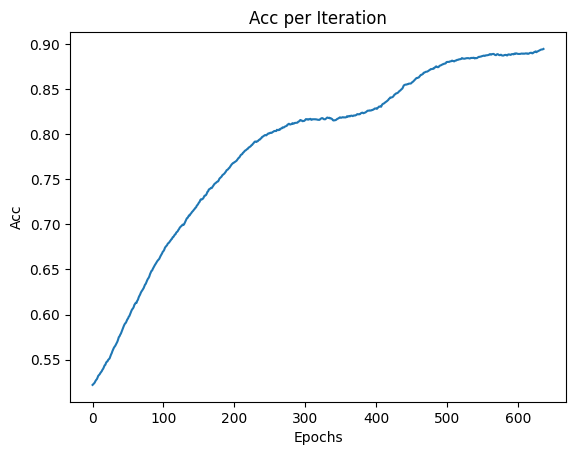

In [23]:
import numpy as np
import matplotlib.pyplot as plt
win_size = 100
smoothed_accuracy = np.convolve(acc_list, np.ones(win_size) / win_size, mode='valid')
plt.plot(smoothed_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title('Acc per Iteration')
plt.show()

In [24]:
len(torch.unique(message))

9

In [25]:
message

tensor([1, 4, 5, 9, 6, 3, 3, 7, 6, 2, 9, 3, 3, 9, 3, 3, 6, 7, 3, 7, 4, 9, 7, 1,
        7, 6, 0, 1, 5, 3, 0, 3, 9, 7, 6, 4, 7, 6, 5, 7, 1, 2, 0, 5, 1, 2, 9, 2,
        5, 0, 7, 2, 0, 9, 7, 6, 0, 9, 2, 5, 7, 4, 4, 3, 2, 1, 3, 5, 6, 3, 1, 7,
        9, 5, 9, 3, 3, 5, 2, 3, 5, 5, 7, 7, 6, 6, 9, 6, 9, 3, 4, 9, 3, 1, 3, 2,
        4, 7, 4, 9, 2, 6, 6, 3, 3, 3, 9, 3, 3, 7, 9, 3, 3, 4, 7, 3, 6, 5, 3, 3,
        7, 7, 3, 6, 7, 6, 7, 9])

In [26]:
colors_images = {x:[] for x in range(10)}
for i in range(30):
  colors_images[message[i].item()].append(batch[i])

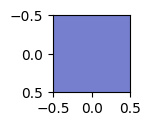

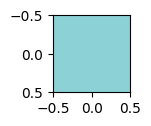

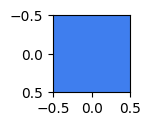

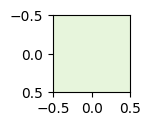

In [37]:
selected_alph = 9
for image in colors_images[selected_alph]:
  fig = plt.figure(figsize=(1, 1))
  plt.imshow(image)
  plt.show()